In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import pprint
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor, Lasso, ElasticNet, Ridge, LassoCV, ElasticNetCV, RidgeCV, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, completeness_score, homogeneity_score, v_measure_score, adjusted_mutual_info_score
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from timeit import default_timer as timer

import pydotplus
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

### NLP
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict




In [2]:
ag = pd.read_csv('age_gender_bkts.csv')
cty = pd.read_csv('countries.csv')
sample_submission = pd.read_csv('sample_submission_NDF.csv')
sessions = pd.read_csv('sessions.csv')
df_test = pd.read_csv('test_users.csv')
df_train = pd.read_csv('train_users_2.csv')

In [3]:
sessions.shape, df_train.shape, df_test.shape

((10567737, 6), (213451, 16), (62096, 15))

In [4]:
df_train.head()

id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0             direct               untracked        Web       Mac Desktop   
1             google               untracked        Web       Mac Desktop   
2             direct               untracked        Web   Windows Desktop   
3             direct               untracked        Web       Mac Desktop   
4             direct               untracked        Web       Mac Desktop   

  first_browser country_destination  
0        Chrome                 NDF  
1        Chrome                 NDF  
2            IE                  US  
3       Firefox               other  
4        Chrome                  US

In [5]:
df_test.head()

id date_account_created  timestamp_first_active  \
0  5uwns89zht           2014-07-01          20140701000006   
1  jtl0dijy2j           2014-07-01          20140701000051   
2  xx0ulgorjt           2014-07-01          20140701000148   
3  6c6puo6ix0           2014-07-01          20140701000215   
4  czqhjk3yfe           2014-07-01          20140701000305   

   date_first_booking     gender   age signup_method  signup_flow language  \
0                 NaN     FEMALE  35.0      facebook            0       en   
1                 NaN  -unknown-   NaN         basic            0       en   
2                 NaN  -unknown-   NaN         basic            0       en   
3                 NaN  -unknown-   NaN         basic            0       en   
4                 NaN  -unknown-   NaN         basic            0       en   

  affiliate_channel affiliate_provider first_affiliate_tracked signup_app  \
0            direct             direct               untracked      Moweb   
1            direct             direct               untracked      Moweb   
2            direct             direct                  linked        Web   
3            direct             direct                  linked        Web   
4            direct             direct               untracked        Web   

  first_device_type  first_browser  
0            iPhone  Mobile Safari  
1            iPhone  Mobile Safari  
2   Windows Desktop         Chrome  
3   Windows Desktop             IE  
4       Mac Desktop         Safari

# EDA

In [6]:
cf.go_offline()
df_train['country_destination'].value_counts().iplot(kind='bar', title='Plot of counts of destinations', yTitle = 'Count', xTitle = 'Destinations')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

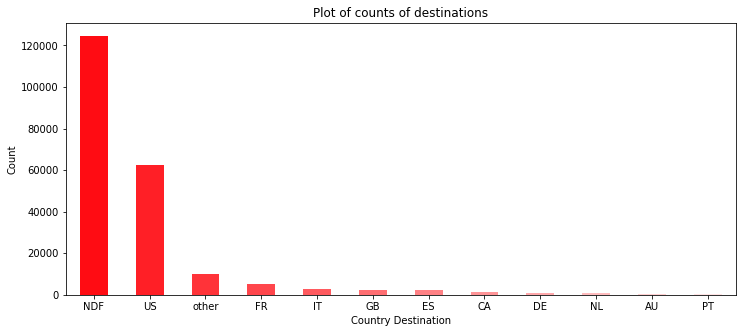

In [56]:
plt.figure(figsize=(12,5))
df_train['country_destination'].value_counts().plot(kind='bar', title='Plot of counts of destinations', color=['#ff0c13', '#ff1f26', '#ff3339', '#ff464c', '#ff5a5f', '#ff6e72', '#ff8185' , '#ff9598', '#ffa8ab','#ffbcbe','#ffd0d1','#ffe3e4'])
plt.ylabel('Count')
plt.xlabel('Country Destination')
plt.xticks(rotation='horizontal')

Text(0.5, 1.0, 'Plot of number of people on each signup_flow category, hue=flew or not')

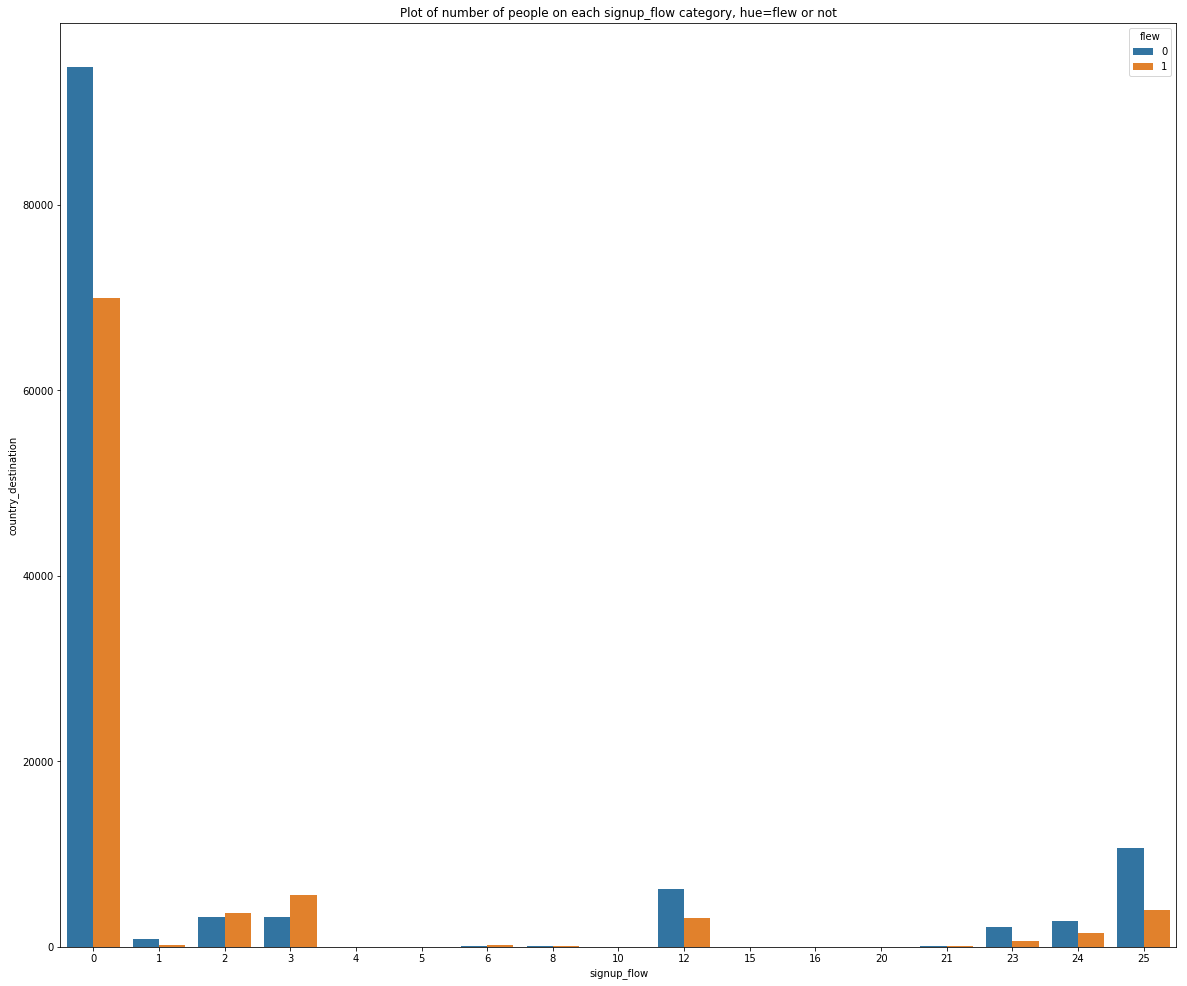

In [7]:
df_plot = df_train.copy(deep=True)
df_plot['flew'] = [0 if val == 'NDF' else 1 for val in df_plot['country_destination']]
plt.figure(figsize=(20,17))
sns.barplot(x='signup_flow', y='country_destination', hue='flew', data= df_plot.groupby(['signup_flow','flew']).count()['country_destination'].reset_index())
plt.title('Plot of number of people on each signup_flow category, hue=flew or not')

Text(0.5, 0, 'Affiliate Channel')

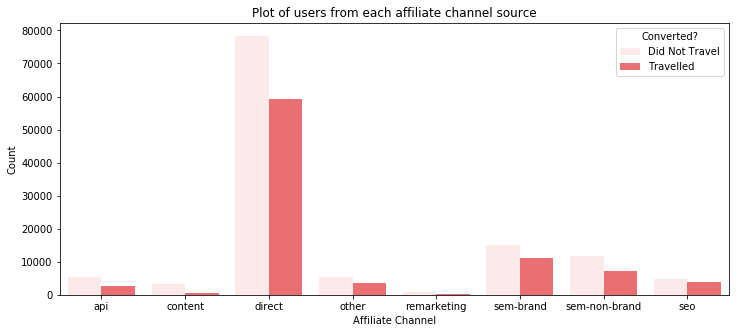

In [25]:
df_plot = df_train.copy(deep=True)
df_plot['Converted?'] = ['Did Not Travel' if val == 'NDF' else 'Travelled' for val in df_plot['country_destination']]
plt.figure(figsize=(12,5))
sns.barplot(x='affiliate_channel', y='id', hue='Converted?', color='#FF5A5F', data=df_plot.groupby(['affiliate_channel','Converted?']).count()['id'].reset_index())
plt.title('Plot of users from each affiliate channel source')
plt.ylabel('Count')
plt.xlabel('Affiliate Channel')

Text(0.5, 1.0, 'Plot of number of people on each first_device_type category, hue=flew or not')

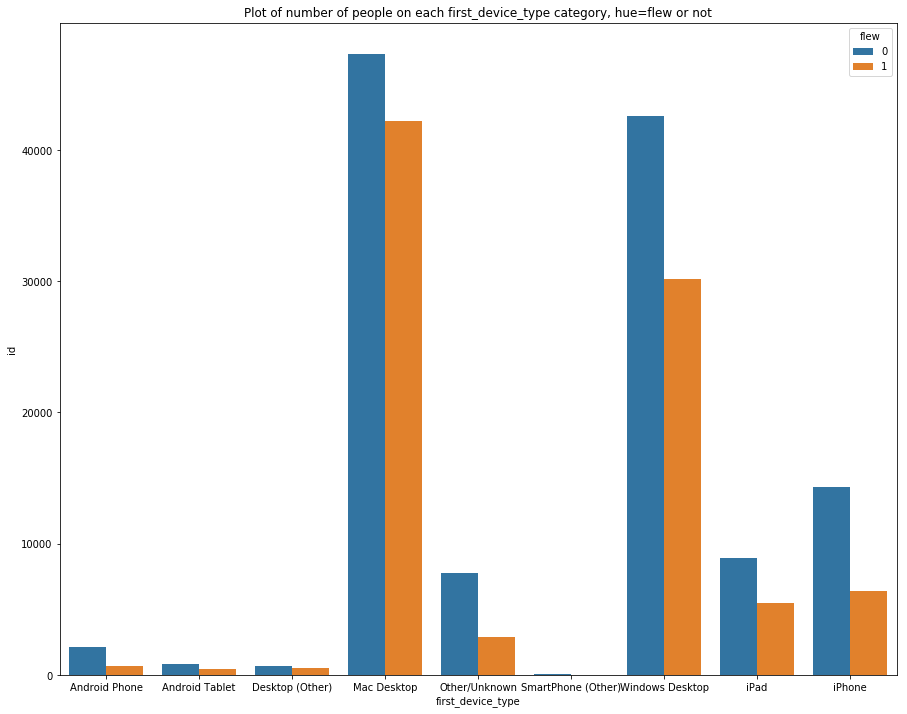

In [9]:
df_plot = df_train.copy(deep=True)
df_plot['flew'] = [0 if val == 'NDF' else 1 for val in df_plot['country_destination']]
plt.figure(figsize=(15,12))
sns.barplot(x='first_device_type', y='id', hue='flew', data=df_plot.groupby(['first_device_type','flew']).count()['id'].reset_index())
plt.title('Plot of number of people on each first_device_type category, hue=flew or not')

Text(0.5, 1.0, 'Plot of number of people on each signup_method category, hue=country_destinations')

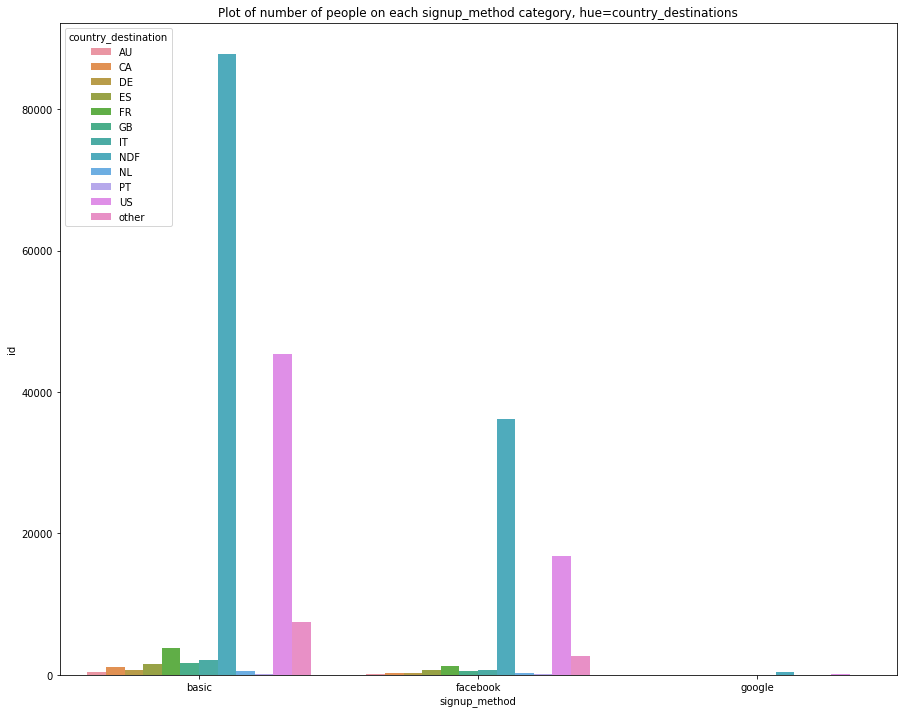

In [10]:
df_plot = df_train.copy(deep=True)
df_plot['flew'] = [0 if val == 'NDF' else 1 for val in df_plot['country_destination']]
plt.figure(figsize=(15,12))
sns.barplot(x='signup_method', y='id', hue='country_destination', data=df_plot.groupby(['signup_method','country_destination']).count()['id'].reset_index())
plt.title('Plot of number of people on each signup_method category, hue=country_destinations')

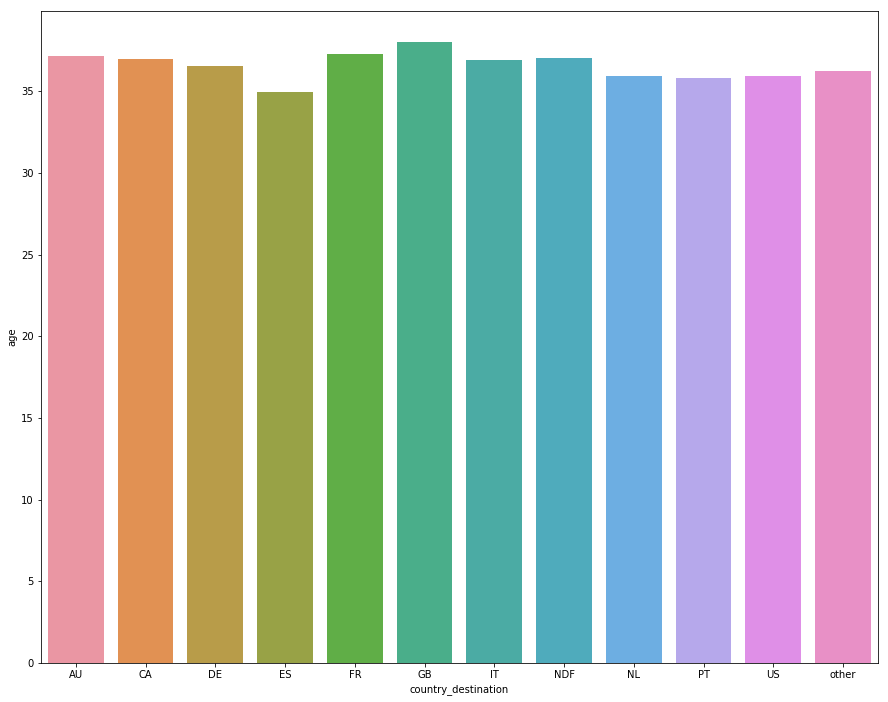

In [11]:
df_plot3 = df_train.copy(deep=True)
df_plot3['flew'] = [0 if val == 'NDF' else 1 for val in df_plot3['country_destination']]
plt.figure(figsize=(15,12))
sns.barplot(x='country_destination', y='age', data=df_plot3[df_plot3['age'] <= 100].groupby('country_destination').mean()['age'].reset_index())

flew
0    1.283576e+06
1    1.875294e+06
Name: secs_elapsed, dtype: float64

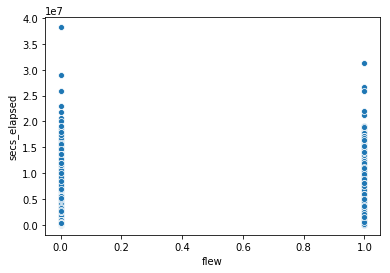

In [12]:
df_plot5 = df_train.copy(deep=True)
df_plot5['flew'] = [0 if val == 'NDF' else 1 for val in df_plot5['country_destination']]

supa_sessions = sessions.groupby('user_id').sum()['secs_elapsed']

df_plot5 = df_plot5.merge(supa_sessions.reset_index(), how='left', left_on='id', right_on='user_id')
df_plot5
sns.scatterplot(x='flew', y='secs_elapsed', data=df_plot5)
df_plot5.groupby('flew').mean()['secs_elapsed']

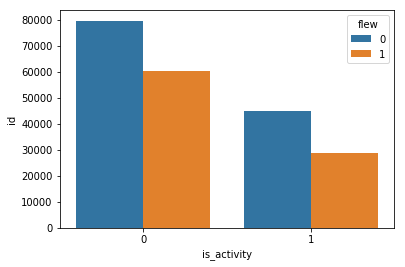

In [13]:
df_plot5 = df_train.copy(deep=True)
df_plot5['flew'] = [0 if val == 'NDF' else 1 for val in df_plot5['country_destination']]

supa_sessions = sessions.groupby('user_id').sum()['secs_elapsed']

df_plot5 = df_plot5.merge(supa_sessions.reset_index(), how='left', left_on='id', right_on='user_id')

df_plot5['is_activity'] = [0 if np.isnan(val) else 1 for val in df_plot5['secs_elapsed']]
sns.barplot(x='is_activity', y='id', hue='flew', data=df_plot5.groupby(['flew', 'is_activity']).count()['id'].reset_index())

Text(0.5, 1.0, 'Avg Time Spent on <<Similar Listings>> for user who flew and doesnt')

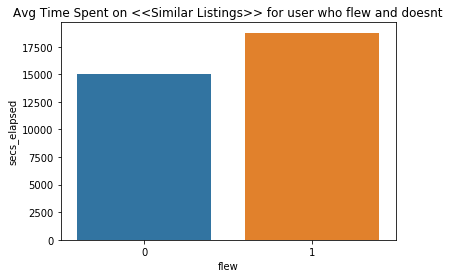

In [14]:
df_plot5 = df_train.copy(deep=True)
df_plot5['flew'] = [0 if val == 'NDF' else 1 for val in df_plot5['country_destination']]

similar_listing_sessions = sessions[sessions['action']=='similar_listings'].groupby('user_id').sum()['secs_elapsed']

df_plot5 = df_plot5.merge(similar_listing_sessions.reset_index(), how='left', left_on='id', right_on='user_id')

df_plot5['is_activity'] = [0 if np.isnan(val) else 1 for val in df_plot5['secs_elapsed']]
sns.barplot(x='flew', y='secs_elapsed', data=df_plot5.groupby(['flew']).mean()['secs_elapsed'].reset_index())
plt.title('Avg Time Spent on <<Similar Listings>> for user who flew and doesnt')

flew
0    8239.412562
1    7737.193483
Name: secs_elapsed, dtype: float64

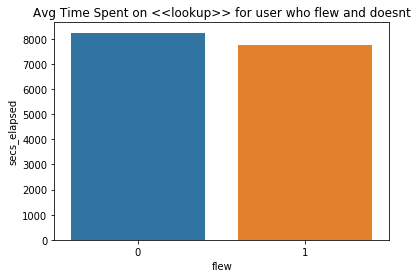

In [15]:
df_plot5 = df_train.copy(deep=True)
df_plot5['flew'] = [0 if val == 'NDF' else 1 for val in df_plot5['country_destination']]

similar_listing_sessions = sessions[sessions['action']=='lookup'].groupby('user_id').sum()['secs_elapsed']

df_plot5 = df_plot5.merge(similar_listing_sessions.reset_index(), how='left', left_on='id', right_on='user_id')

sns.barplot(x='flew', y='secs_elapsed', data=df_plot5.groupby(['flew']).mean()['secs_elapsed'].reset_index())
plt.title('Avg Time Spent on <<lookup>> for user who flew and doesnt')
df_plot5.groupby(['flew']).mean()['secs_elapsed']

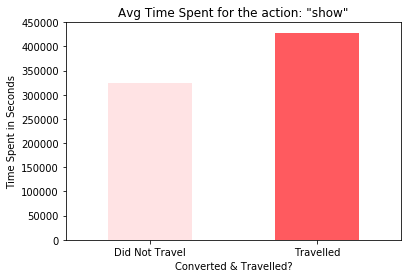

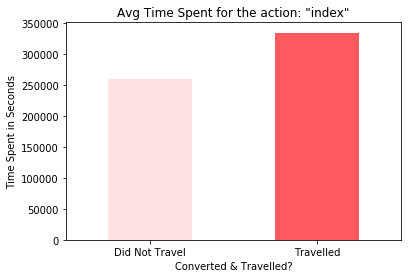

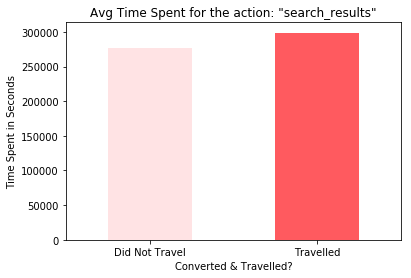

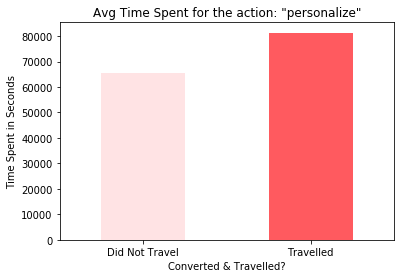

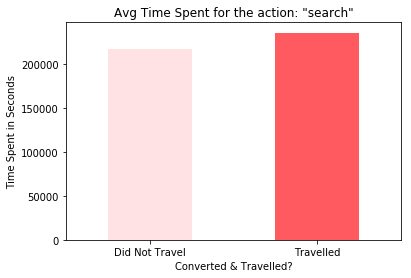

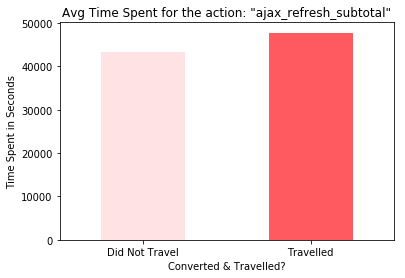

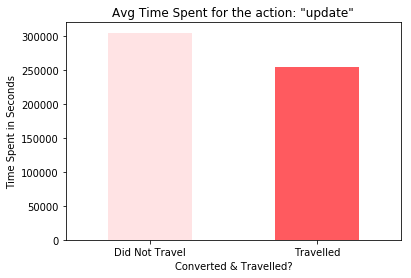

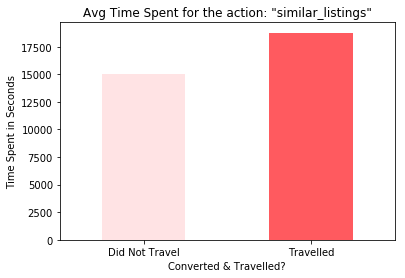

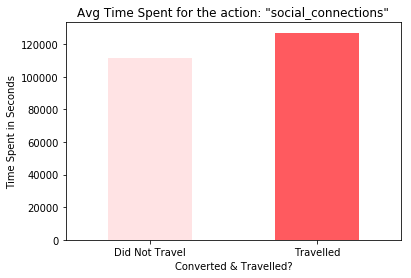

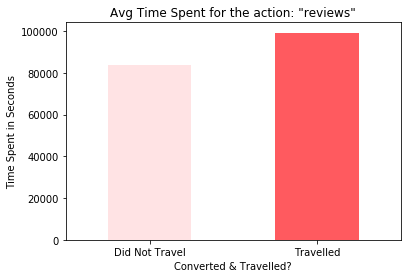

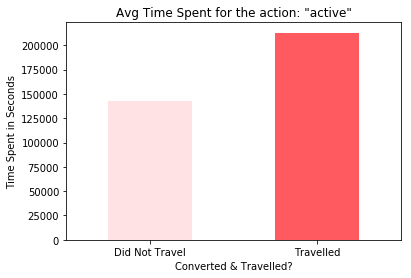

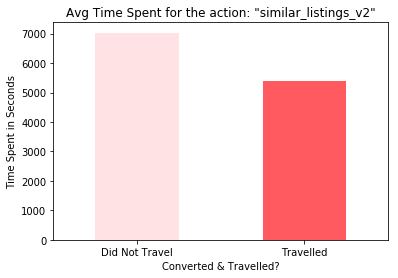

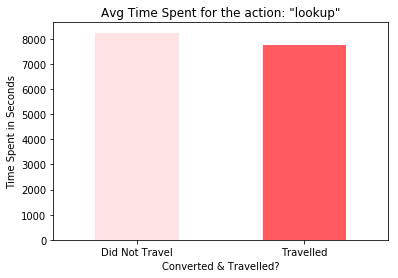

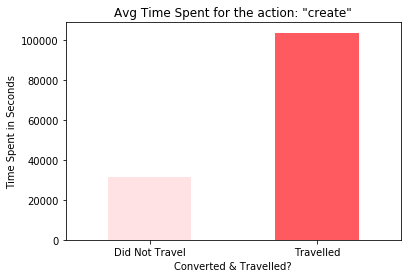

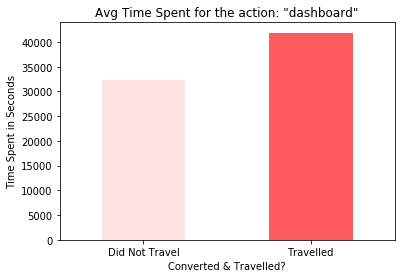

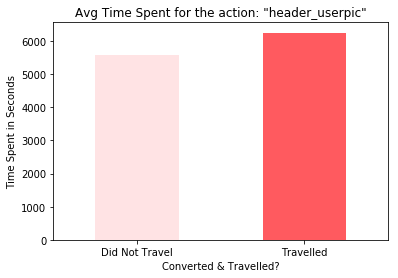

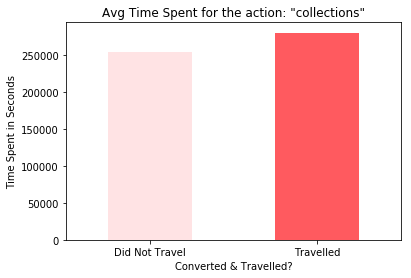

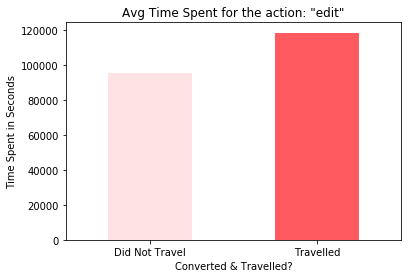

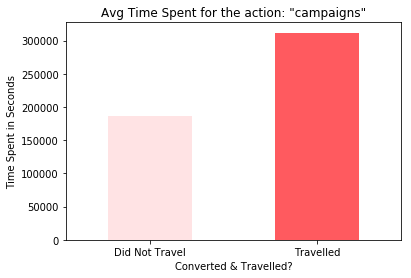

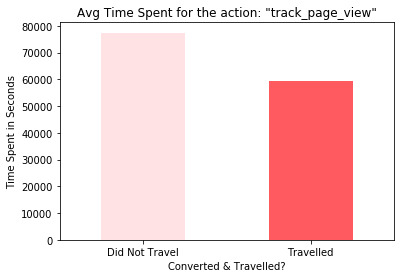

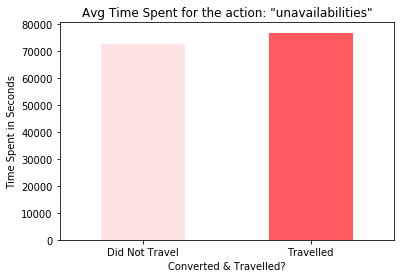

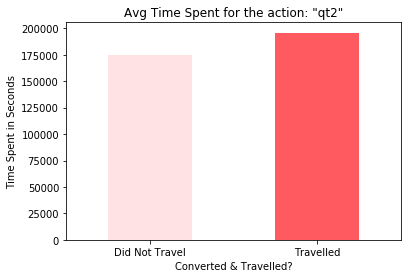

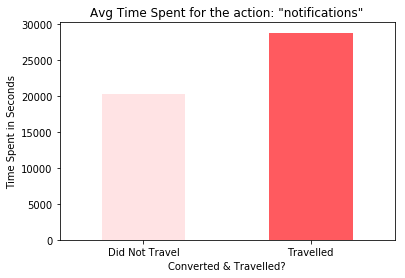

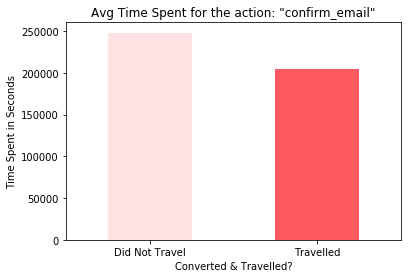

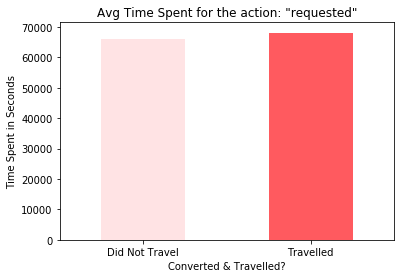

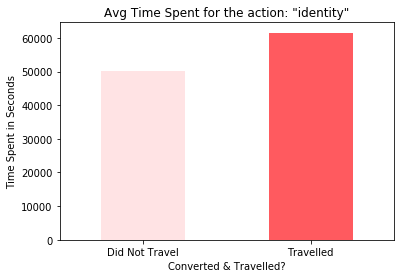

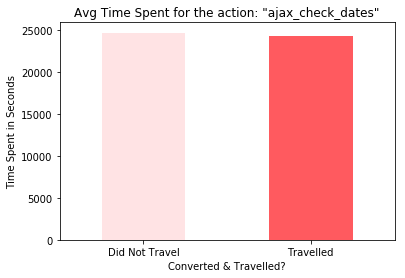

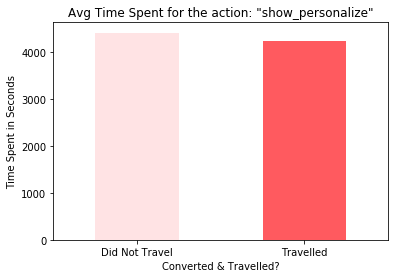

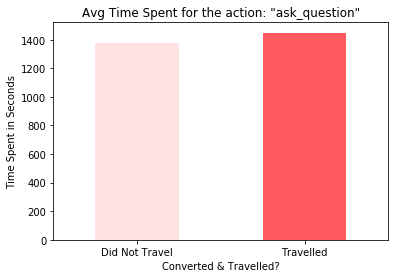

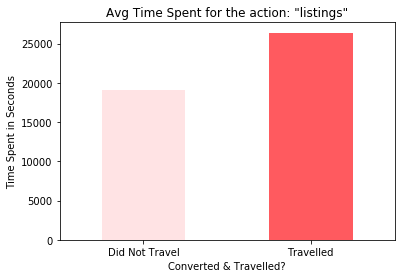

In [54]:
df_plot5 = df_train.copy(deep=True)
df_plot5['Converted?'] = ['Did Not Travel' if val == 'NDF' else 'Travelled' for val in df_plot['country_destination']]
#FF5A5F
dict_timescore = {}
timescore_list = []

for action in sessions['action'].value_counts().index[:30]:
    
    similar_listing_sessions = sessions[sessions['action']==action].groupby('user_id').sum()['secs_elapsed']
    df_plot_holding = df_plot5.merge(similar_listing_sessions.reset_index(), how='left', left_on='id', right_on='user_id')
#    sns.barplot(x='Converted?', y='secs_elapsed', hue='Converted?', color='#FF5A5F', data=df_plot_holding.groupby(['Converted?']).mean()['secs_elapsed'].reset_index())
    df_plot_holding.groupby(['Converted?']).mean()['secs_elapsed'].plot(kind='bar', color=['#ffe3e4', '#FF5A5F'])
    plt.title('Avg Time Spent for the action: "{}"'.format(action))
    plt.ylabel('Time Spent in Seconds')
    plt.xlabel('Converted & Travelled?')
    plt.xticks(rotation='horizontal')
#     plt.legend()
    plt.show()
testing123 = df_plot_holding.groupby(['Converted?']).mean()['secs_elapsed'].reset_index()
#    timescore = df_plot_holding.groupby(['Converted?']).mean()['secs_elapsed'][1] - df_plot_holding.groupby(['Converted?']).mean()['secs_elapsed'][0]
#     dict_timescore[timescore] = action
#     timescore_list += [timescore]

(array([0, 1]), <a list of 2 Text xticklabel objects>)

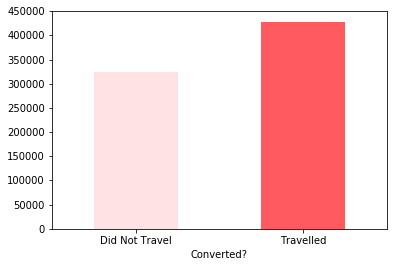

In [52]:
df_plot_holding.groupby(['Converted?']).mean()['secs_elapsed'].plot(kind='bar', color=['#ffe3e4', '#FF5A5F'])
plt.xticks(rotation='horizontal')

In [21]:
len(df_train.columns)

16

In [22]:
len(sessions['action'].unique())

360

In [25]:
len(df_test.index)

62096

In [26]:
df_train.head()

id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender   age signup_method  signup_flow language affiliate_channel  \
0  -unknown-   NaN      facebook            0       en            direct   
1       MALE  38.0      facebook            0       en               seo   
2     FEMALE  56.0         basic            3       en            direct   
3     FEMALE  42.0      facebook            0       en            direct   
4  -unknown-  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0             direct               untracked        Web       Mac Desktop   
1             google               untracked        Web       Mac Desktop   
2             direct               untracked        Web   Windows Desktop   
3             direct               untracked        Web       Mac Desktop   
4             direct               untracked        Web       Mac Desktop   

  first_browser country_destination  
0        Chrome                 NDF  
1        Chrome                 NDF  
2            IE                  US  
3       Firefox               other  
4        Chrome                  US